$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\given}[]{~\middle\vert~}
$$

# CS236605: Deep Learning
# Tutorial 7: Deep Reinforcement Learning

## Introduction

In this tutorial, we will cover:

- The reinforcement learning setting
- OpenAI gym
- Deep $q$-learning

In [60]:
# Setup
%matplotlib inline
import os
import sys
import math
import time
import torch
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 20
data_dir = os.path.expanduser('~/.pytorch-datasets')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'running on: {device}')

running on: cuda


## Theory Reminders: The RL setting

Reinforcement learning is a general framework of a learning setting which includes:
- An agent: something which interacts, or performs actions on an **environment** on our behalf,
  according to some deterministic or stochcastic policy.
- Actions: Things that the agent can do.
- An environment: Everything outside of the agent's control. The agent can (partially) observe it's state,
  and it periodically gets rewards from the environment.
- Observations: Things about the state of the environment which the agent can periodically observe.
- Reward: A scalar value which the agent receives from the environment after (some) actions.

<img src="img/rl_setting2.png" width="700"/>

**Example**: Stock market trading
- Agent: a trading system or algorithms which can buy and sell stocks, bonds, etc. 
- Actions: what to buy or sell, and how much.
- Environment: The entire market and everything that may potentially influence it (news events, politics, economic conditions, etc). Potentially everything in the universe.
- Observations: Stock prices, market indices, etc.
- Reward: Total accumulated profit.

So far we have seen two types of learning paradigms:
- Supervised, in which we learn a mapping based on labelled samples;
- Unsupervised, in which we learn the latent structure of our data.

Reinforcement learning is a different paradigm which doesn't cleanly map into either supervised or unsupervised.

- On one hand, there are no predefined labels.
- However, instead we have a **reward system**, which guides the learning process through.
- By observing rewards (which can be positive, negative or neutral) we expect our agent to learn what actions (and which states) lead to positive rewards.
- In essence, we **create our own labels** based on the experiences of the agent.

The RL setting presents some unique challenges.

- Non i.i.d observations
    - since they depend on the agent
    - we might only observe only non-useful information
- Exploration vs. exploitation trade-off
    - discovering new strategies may be at the cost of short term rewards loss
- Delayed reward: can even be one single reward at the end
    - need to discover causal relations between actions and rewards despite the delays

### Markov processes

A **Markov process** (MP; aka Markov chain), is a system with a finite number of **states**, and time-invariante **transition probabilities** between them.
- **Markov property**: transition probabilities to next state depend only on current state.
- At each time step $t$, the next state $S_{t+1}$ is sampled based on the current state $S_{t}$.
- Fully described by states $\cset{S}=\{s_i\}_{i=1}^{N}$ and transition matrix
  $$P_{i,j}=P(s_i,s_j)=\Pr(S_{t+1}=s_j|S_{t}=s_i).$$
- Some states, $\cset{S}_T\subset\cset{S}$, may be terminal, i.e.
  $\forall s\in\cset{S}_T, s'\in\cset{S}:~P(s,s')=0$.

A **Markov reward process** (MRP) is an MP where in addition we have,
- Immediate reward for transition from state $s_i$ to state $s_j$: $R_{i,j} = R(s_i,s_j)$.
- Discount factor $\gamma\in[0,1]$ for future rewards.

Total discounted reward (aka gain) from time $t$:
$$
G_t = R_{t+1}+\gamma R_{t+2} + \dots = \sum_{k=0}^{\infty} \gamma^k R_{t+1+k}.
$$

The **value** of a state $s$ it's it's expected future return:
$$
v(s) = \E{G_t|S_t = s}.
$$

A **Markov desicion process** (MDP) is an MRP where in addition,
- We have a finite set of **actions** that can be performed by our agent at each state: $\cset{A}=\{a_k\}_{k=1}^{K}$.

- The transition probabilities are now action-dependent:
   $$P_{i,j,k} = P_{a_k}(s_i,s_j) = \Pr(S_{t+1}=s_j|S_t=s_i,A_t=a_k).$$
   <img src="img/mdp_transition_prob.png" width="500"/>

- The immediate reward is now also action-dependent. We will also ignore the dependence on the next state:
$$
R_{t+1} = R(S_t,A_t).
$$

We define the **policy** of an agent as the conditional distribution,
$$
\pi(a|s) = \Pr(A_t=a\vert S_t=s).
$$
This defines the actions the agent is likely to take at state $s$. Assumed to be time invariant.

The **state-value function** of an MDP is now policy-dependent:

\begin{align}
v_{\pi}(s) &= \E{G_t|S_t = s,\pi} \\
&= \E{\sum_{t=0}^{\infty} \gamma^t R_{t+1}\given S_0=s, \pi} \\
&= \E{R_1 +\gamma v_\pi(S_1) \given S_0=s, \pi}.
\end{align}

Notice:
1. The state value is the *expected immediate return* plus the *expected discounted value of the next state*.
2. The expectation is over the selected action (under the policy distribution) and the next state due to this action.

Writing the expectation explicitly for the state-value function, we get:

$$
v_{\pi}(s) =
\sum_{a\in\cset{A}}\pi(a|s)R(s,a) +
\gamma \sum_{a\in\cset{A}} \sum_{s'\in\cset{S}} \pi(a|s) P_{a}(s,s') v_{\pi}(s').
$$

<img src="img/v_expectation.png" width="500" />


Example MDP with computed state values (not optimal)

<img src="img/mdp.png" width="700"/>


Value of the right study state:
$$
0.5\cdot(1+0.2\cdot -1.3 + 0.4 \cdot 2.7 + 0.4\cdot 7.4) + 0.5\cdot (10+0) = 7.4
$$

We also define an **action-value function** which is the expected return of a an agent starting at state $s$ and performing action $a$:

\begin{align}
q_{\pi}(s,a) &= \E{G_t|S_t = s,A_t=a,\pi} \\
&= \E{\sum_{t=0}^{\infty} \gamma^t R_{t+1}\given S_0=s, A_0=a, \pi} \\
&= \E{R_1 + \gamma q_{\pi}(S_1,A_1) \given S_0=s, A_0=a, \pi}.
\end{align}

Similarly to before, we can write the expectation explicitly for the action-value function:

$$
q_{\pi}(s,a) =
R(s,a) +
\gamma \sum_{s'\in\cset{S}} P_{a}(s,s') \sum_{a'\in\cset{A}} \pi(a'|s') q_{\pi}(s',a').
$$

<img src="img/q_expectation.png" width="500" />


Notice that if instead of taking the expectation over actions we take the action with the maximal value,
we'll get a better action-value for our current state.

Therefore, any **optimal** action-value function $q^\ast$ must satisfy

$$
q^\ast(s,a) =
R(s,a) +
\gamma \sum_{s'\in\cset{S}} P_{a}(s,s') \max_{a'\in\cset{A}} q^\ast(s',a'),
$$
which is known as the **Bellman optimiality equation**.

- For any MDP, there is always at least one **deterministic optimal policy**.
- If we somehow know the optimal action value function, $q^\ast(s,a)$, we can get an optimal policy:

$$
\pi^\ast(a|s) =
\begin{cases}
1, & a = \arg\max_{a'\in\cset{A}} q^\ast(s,a') \\
0, & \text{else}
\end{cases}
$$

- In the RL setting, we generally assume an MDP-based environment, however we **do not** assume that $P$ and $R$ are known.
- Therefore, the challenge is to learn both the action value function (or the policy directly)
  while simultaneously also learning the underlying environment dynamics ("rules of the game").

### Experiences and Episodes

These are two important RL terms which are commonly used in the context of
gathering data from and training RL models on this data.

- An **experience** is a tuple $(S_t,A_t,R_{t+1},S_{t+1})$. It represents what happened to an agent due to his action at time $t$.

- An **episode** is a sequence of experiences
  $$
  \left\{ (S_0,A_0,R_1), (S_1,A_1,R_2), \dots \right\}
  $$
  which represents one entire "game" for the agent.
  

<img src="img/rl_episodes.png" width="1000" />


## OpenAI Gym

<img src="https://gym.openai.com/assets/dist/home/header/home-icon-54c30e2345.svg" width="150" />

From the official [site](https://gym.openai.com):

    Gym is a toolkit for developing and comparing reinforcement learning algorithms. 
    It supports teaching agents everything from walking to playing games
    like Pong or Pinball.

In RL terms, `gym` will provide us an **environment** which comes with states,
possible actions and rewards.
We will implement our **agent** to work with these environments.

We'll see a quick example and then explain what's going on and how to use `gym`.

Let's play the classic Atari game **Space Invaders**, using a randomly-playing agent.

<img src="img/Space_Invaders_flyer_1978.jpg" />


In [61]:
import gym
from gym.wrappers import Monitor

# Create a new SpaceInvaders environment
# Wrap it in a Monitor so that we record video
with Monitor(gym.make('SpaceInvaders-v0'), "out", force=True) as env:
    
    # Reset the env to start a new episode
    env.reset()
    episode_done = False
    total_reward = 0
    total_steps = 0
    
    # This is our agent code. It will just play randomly.
    # As long as the episode is not done (not Game Over), we:
    while not episode_done:
        # 1. Choose a random valid action to do
        action = env.action_space.sample()
        
        # 2. Do the random action and get feedback from the environment
        obs, reward, episode_done, extra_info = env.step(action)
        
        total_reward += reward
        total_steps += 1

print(f'Played {total_steps} steps. Total reward: {total_reward}')

Played 769 steps. Total reward: 210.0


How do we see what happened?

We have a video recording of the last episode generated by our `Monitor`.

In [62]:
import IPython.display

# A helper function that shows the last video from a Monitor env wrapper
def show_last_video(monitor_env, width='auto', height='auto'):
    video_path = monitor_env.videos[-1][0]
    video_path = os.path.relpath(video_path, start=os.path.curdir)
    
    raw_html = f'<video src="{video_path}" controls autoplay width="{width}" height="{height}" />'
    return IPython.display.HTML(data=raw_html)

In [63]:
print('Our random agent in action:')
show_last_video(env, width=400)

Our random agent in action:


`gym` offeres many other available environments:  
 <https://gym.openai.com/envs>

### Anatomy of an `Environment`

Let's dig in a bit deeper to see what we're working with when using `gym`'s `Environment`s.

Usually, the `Environment` you use is actually multiple environments, each wrapping another.

In [64]:
env = gym.make('SpaceInvaders-v0')
env?

#### Observations

In [65]:
# Starts a new episode, returning an initial observation
obs = env.reset()

What are we observing exactly?

In [66]:
print(type(obs))
obs.shape

<class 'numpy.ndarray'>


(210, 160, 3)

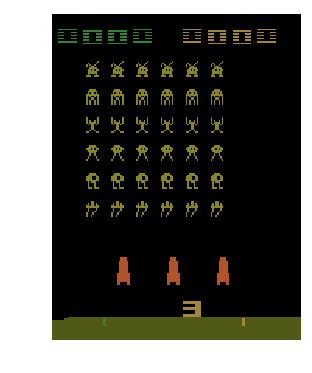

In [67]:
def show_observation(obs, size=6, cmap=None):
    f, ax = plt.subplots(1,1,figsize=(size,size))
    ax.imshow(obs, cmap=cmap)
    ax.axis('off')

show_observation(obs)

What is space of possible observations?

In [68]:
env.observation_space

Box(210, 160, 3)

`Box` is a `Space` which represents an n-dimentinoal Tensor with values in range [low, high].

In [69]:
(env.observation_space.low.reshape(-1)[0],
env.observation_space.high.reshape(-1)[0])

(0, 255)

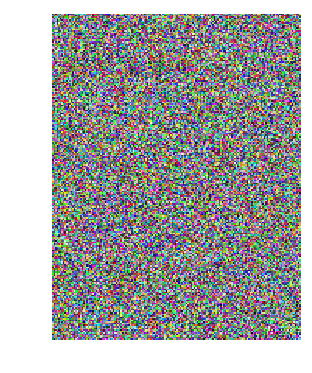

In [70]:
obs_sample = env.observation_space.sample()

show_observation(obs_sample)

#### Actions

What **actions** can we perform in this environment?

In [71]:
env.action_space

Discrete(6)

`Discrete` is a `Space` which represents `n` integers with values `0,1,...,n-1`.

In this case, this means we have 6 possible actions we can choose from at each step of our game.

In [72]:
print(env.action_space.contains(0))
print(env.action_space.contains(6))

True
False


But what do they mean? It's game specific. For the Atari environments:

In [73]:
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

How do we perform **actions** on the environment?

reward=0.0, done=False, exrta_info={'ale.lives': 0}


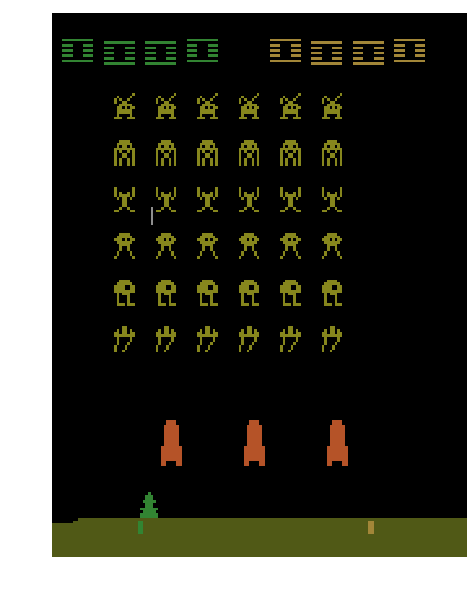

In [74]:
env.reset()

fire_action = 1

# Run for a few (simulated) seconds
fps = 30
seconds = 2
for _ in range(fps*seconds):
    obs, reward, episode_done, exrta_info = env.step(fire_action)

show_observation(obs, size=10)
print(f'reward={reward}, done={episode_done}, exrta_info={extra_info}')

In [75]:
# When done, need to close() the environment
env.close()

#### Wrappers

`Wrapper`s allow you to **wrap** an `Environment` instance and modify it's behavior.

We have already used the `Monitor` wrapper, which writes the observation as a video frame each step, and also outputs data about the agents progress during the episode.

There are some pre-defined wrapper types which allow you to easily intervene in the interaction between your agent and the environment:
- `ObservationWrapper` allows you to modify the **observations** before they get to the agent.
- `RewardWrapper` allows you to modify the **reward** before it gets to the agent.
- `ActionWrapper` allows you to modify the agent's action before it gets to the environment.

In [76]:
class MalfunctioningScreenWrapper(gym.ObservationWrapper):
    # Override the observation() method from ObservationWrapper to change the observation
    # on the way to the agent
    def observation(self, obs: np.ndarray):
        r = np.random.randint(10)
        # Invert colors and with a low probability set a single channel
        obs  = 255 - obs
        if r < 3:
            obs[:,:,r] = 128
            
        self.last_obs = obs
        return obs
    
    # Change render() to show modified observations in video
    def render(self, mode, **kw):
        r = self.env.render(mode, **kw)
        return self.observation(r) if mode == 'rgb_array' else r

In [77]:
class TriggerHappyWrapper(gym.ActionWrapper):
    # Override the action() method from ActionWrapper to change the action
    # on the way to the environment
    def action(self, act):
        # With a high probability, just do the FIRE action
        if np.random.random() < 0.9:
            return 1
        else:
            return act

Lets see our `Wrapper`s in action:

In [78]:
env = \
MalfunctioningScreenWrapper(
    TriggerHappyWrapper(
        gym.make('SpaceInvaders-v0')
    )
)
with Monitor(env, 'out', force=True) as env:
    env.reset()
    episode_done = False
    total_reward = 0
    total_steps = 0
    while not episode_done:
        action = env.action_space.sample()
        obs, reward, episode_done, extra_info = env.step(action)
        total_reward += reward
        total_steps += 1

print(f'Played {total_steps} steps. Total reward: {total_reward}')

Played 372 steps. Total reward: 80.0


In [79]:
show_last_video(env, width=400)

## Deep $q$-learning for Atari games

We'll now implement a $q$-learning method using a deep neural network to approxiamte the action value function $q(s,a)$ in an Atari game. We'll teach our model to play by directly observing the game **pixels**, as a human would.

This is based on the [seminal paper](https://www.nature.com/articles/nature14236.pdf)
"Human-level control through deep reinforcement learning", 
by Volodymyr Mnih, David Silver and others from Google DeepMind (Nature, 2015).

### Approach

- We will learn a parametrized function $q_{\Theta}(s,a)$ representing the **action-value** function, implemented as a CNN.
- We'll treat the task of learning $q_\Theta$ as a **regression** problem.
- During training, we'll collect **experiences**. We'll denote the $i$th experience as
  $$
    \vec{x}^{i} = (s^i,a^i,r^i,{s'}^i).
  $$

- Our point-wise loss will be an MSE loss,
  $$
  \ell_i(\Theta) = \left(y^i-q_\Theta(s^i,a^i)\right)^2,
  $$
  where the label, $y^i$, is generated by us like so:
  $$
  y^i =
  \begin{cases}
  r^i, & {s'}^i \in \cset{S}_T \\
  r^i + \gamma \max_{a\in\cset{A}} q_{\Theta^-}({s'}^i,a) , &   {s'}^i \in \cset{S}\setminus\cset{S}_T
  \end{cases}
  $$
    - Recall the Bellman equation,
      $$
      q^\ast(s,a) =
      R(s,a) +
      \gamma \sum_{s'\in\cset{S}} P_{a}(s,s') \max_{a'\in\cset{A}} q^\ast(s',a'),
      $$
    - Our label is based on this, while dropping the expectation over the next state, since we don't know $P$.
    - Since we average these point-wise losses over batches over experiences, we will **implicitly** weight them according to $P$.

#### Target network

A major problem with the way we defined our labels is that we seem to be using
the action value of the next state-action pair, $q_\Theta(s',a')$ to update the
current action value $q_\Theta(s,a)$.

- This would mean our labels will be very similar to whatever the current network is outputting.

- Moreover, any update we do at step $t$ will very likely cuase the labels for the next steps to change, since adjacent steps "look similar" to the network.

To overcome this, The label (target) is calculated using a **target network**, i.e. a different parametrization ($\Theta^-$) of the $q$ function. The labels are therefore not dependent on the model being trained.

#### Experience replay

Another issue we must face is the non-i.i.d nature of our samples (experiences).

By definition, every experience our agent has is highly dependent on all previous
experiences in the episode.
- SGD critically depends on i.i.d-ness of samples (otherwise, gradient of batches does not, in expectation, equal the actual gradient of the dataset).

Moreover, we only have experiences that are based on some current, **sub-optimal** policy,
not the actual policy that we want to discover.
- If we only update our parameters based on that, we may get stuck in sub-optimal loops.

The solution is an **Experience replay buffer**:
- We store the $N$ most-recent experiences, **across different episodes**:
  $$
  D_t=\left\{\vec{x}^i\right\}_{i=t-N}^{t} =
  \left\{(s^i,a^i,r^i,{s'}^i)\right\}_{i=t-N}^{t}
  $$
- To update our model, we uniformly sample a batch of experiences from $D_t$.

#### $\epsilon$-greedy

Initially, our policy will be very bad since we have a wrong action-value function.

If we let our agent follow this misguided policy and just collect those experiences, we may never get any useful samples.

To overcome this,
- Our agent will take a random action with probability $\epsilon$, and use the current policy with probability $1-\epsilon$.
- As training progresses, we'll slowly decay $\epsilon$ from $1.0$ to something close to zero.

#### Pre-processing

As always, the devil is in the details.
The DeepMind paper uses various preprocessing tricks to improve training time and stability.

- Start playing with some amount of No-Ops.
- Pressing FIRE after resetting the environment, so that the agent doesn't need to learn this part.
- Stopping the episode after a game "life" is lost.
- Fusing together two adjacent frames (by taking the pixel-wise maximum) to reduce flickering.
- Scaling each frame to 84x84 and converting to grayscale.
- Skip $k=4$ frames, applying the same action to in-between frames.
- Stacking together $m=4$ frames (after skipping $k$) into a single observation so that the agent can observe the dynamics of entities (speed, direction). Note that consecutive observations will have overlapping frames.
- Clipping the reward to range [-1,1].

<img src="img/deepmind_frames.png" width="600" />


Luckily, all these preprocessing steps, implemented as `gym` `Wrapper` classes,
can be copied from OpenAI's [baselines](https://github.com/openai/baselines) repo.

We'll just implement one extra custom `Wrapper` to convert images into the PyTorch axis ordering convention.

In [80]:
class CHWImageWrapper(gym.ObservationWrapper):
    """
    Changes the observation image from HxWxC to CxHxW (the PyTorch convention).
    """
    def __init__(self, env):
        super().__init__(env)
        old_shape = self.observation_space.shape
        low = self.observation_space.low.reshape(-1)[0]
        high = self.observation_space.high.reshape(-1)[0]
        shape = (old_shape[-1], old_shape[0], old_shape[1])
        self.observation_space = gym.spaces.Box(low, high, shape, dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

In [81]:
# Use OpenAI's baseline atari_wrappers to create environments
import atari_wrappers

# Create our custom wrapped environment
def make_atari(env_name):
    env = atari_wrappers.make_atari(env_name) 
    env = atari_wrappers.wrap_deepmind(env, frame_stack=True, scale=True)
    env = CHWImageWrapper(env)
    env = gym.wrappers.Monitor(env, 'out', force=True, )
    return env

Let's check our heavily wrapped environment.

<Monitor<CHWImageWrapper<FrameStack<ClipRewardEnv<ScaledFloatFrame<WarpFrame<FireResetEnv<EpisodicLifeEnv<MaxAndSkipEnv<NoopResetEnv<TimeLimit<AtariEnv<SpaceInvadersNoFrameskip-v0>>>>>>>>>>>>>
Box(4, 84, 84)
observation shape: (4, 84, 84)
actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


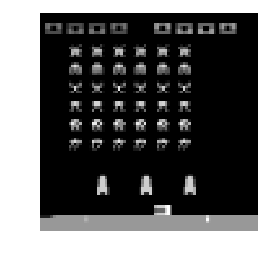

In [82]:
env = make_atari('SpaceInvadersNoFrameskip-v0')
print(env)
print(env.observation_space)

obs = env.reset()
obs = np.array(obs)
obs_shape = obs.shape
print(f'observation shape: {obs_shape}')
env_actions = env.unwrapped.get_action_meanings()
print(f'actions: {env_actions}')
show_observation(obs[3], size=4, cmap='gray')

### DQN Model

The DQN model used in the paper is surprisingly simple. It has just 3 conv layers followed by 2 FC layers.

<img src="img/deepmind_arch.png" width="1000" />


In [83]:
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, in_shape, n_actions):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        n_conv_features = self._calc_num_conv_features(in_shape)
        self.fc = nn.Sequential(
            nn.Linear(n_conv_features, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _calc_num_conv_features(self, in_shape):
        x = torch.zeros(1, *in_shape)
        out_shape = self.conv(x).shape
        return int(np.prod(out_shape))

    def forward(self, x):
        features = self.conv(x)
        features = features.view(x.shape[0], -1)
        return self.fc(features)

As always, lets make sure forward pass works.

In [84]:
model = DQN(obs.shape, len(env_actions)).to(device)
print(model)

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [85]:
x0 = torch.tensor(obs, device=device).unsqueeze(0)
model(x0)

tensor([[ 0.0501, -0.0314, -0.0294, -0.0268,  0.0132, -0.0037]],
       device='cuda:0', grad_fn=<AddmmBackward>)

### Experience replay buffer

In [86]:
from collections import deque

class ExperienceReplayBuffer(object):
    def __init__(self, maxlen, device):
        # dequeue automatically evicts old entries if maxlen reached
        self.buffer = deque(maxlen=maxlen) 
        self.device = device
        
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, i):
        return self.buffer.__getitem__(i)

    def append(self, state, action, reward, is_done, new_state):
        # note: when in buffer, copy to main RAM
        self.buffer.append((state.cpu(), action, reward, is_done, new_state.cpu()))

    def sample(self, batch_size):
        # Sample batch_size random indices from the buffer
        ii = np.random.choice(len(self.buffer), batch_size, replace=False)
        
        # Batches of: state, action, reward, done?, next_state
        s, a, r, d, n = zip(*[self.buffer[i] for i in ii])
        
        return (
            torch.stack(s, dim=0).to(self.device),
            torch.tensor(a, dtype=torch.long).to(self.device),
            torch.tensor(r, dtype=torch.float32).to(self.device),
            torch.tensor(d, dtype=torch.uint8).to(self.device),
            torch.stack(n).to(self.device)
        )
        
    def __repr__(self):
        return self.buffer.__repr__()

### Agent

In [87]:
class DQNAgent:
    def __init__(self, env, q_net, replay_buffer, device):
        self.env = env
        self.q_net = q_net
        self.replay_buffer = replay_buffer
        self.device = device
        self._reset()
        
    def _reset(self):
        self.curr_state = torch.tensor(env.reset(), device=self.device)
        self.curr_episode_reward = 0.0

    def step(self, eps=0.0):
        # With probability eps, select a random action
        if np.random.random() < eps:
            action = env.action_space.sample()
        else:
            # Do a forward pass through the q_net to get q(s,a) for all a.
            q_s = self.q_net(self.curr_state.unsqueeze(0))
            # Select action with highest value of q(s,a).
            _, action = torch.max(q_s, dim=1)
            action = int(action.item())

        # Perform the selected action on the environment to get a reward and a new observation.
        next_state, reward, is_done, _ = self.env.step(action)
        next_state = torch.tensor(next_state, device=self.device)
        self.curr_episode_reward += reward

        # Save this experience in the replay buffer for future training.
        self.replay_buffer.append(self.curr_state, action, reward, is_done, next_state)
        self.curr_state = next_state
        
        # Check if an episode ended. If so, reset and return total reward.
        if not is_done: return None
        episode_reward = self.curr_episode_reward
        self._reset()
        return episode_reward

A quick sanity check for our agent:

buff_len: 100
curr_reward: 0.0


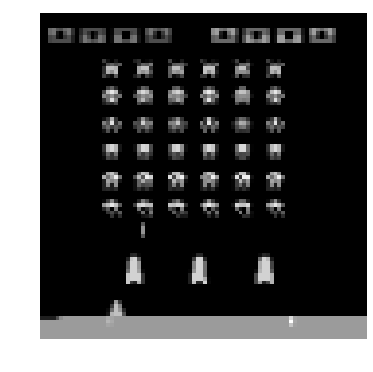

In [88]:
agent = DQNAgent(env, model, ExperienceReplayBuffer(1000, device), device)

for _ in range(100):
    agent.step()

print(f'buff_len: {len(agent.replay_buffer)}')
print(f'curr_reward: {agent.curr_episode_reward}')
show_observation(agent.curr_state.squeeze()[0].cpu().numpy(), cmap='gray')

In [89]:
s, a, r, d, n = agent.replay_buffer.sample(2)

for x in (s,a,r,d,n):
    print(x.shape, x.dtype)

torch.Size([2, 4, 84, 84]) torch.float32
torch.Size([2]) torch.int64
torch.Size([2]) torch.float32
torch.Size([2]) torch.uint8
torch.Size([2, 4, 84, 84]) torch.float32


### Loss function

Recall that our point-wise loss is
$$
\ell_i(\Theta) = \left(y^i-q_\Theta(s^i,a^i)\right)^2,
$$
where the label, $y^i$, is:
$$
y^i =
\begin{cases}
r^i, & {s'}^i \in \cset{S}_T \\
r^i + \gamma \max_{a\in\cset{A}} q_{\Theta^-}({s'}^i,a) , &   {s'}^i \in \cset{S}\setminus\cset{S}_T
\end{cases}
$$

In [90]:
class DQNLoss(nn.Module):
    def __init__(self, q_net, q_target_net, gamma):
        super().__init__()
        self.q_net = q_net
        self.q_target_net = q_target_net
        self.gamma = gamma
        
    def forward(self, s, a, r, d, n):
        """Input is batches of: state, action, reward, done?, next_state"""
        # First, calculate our PREDICTED action-value q(s,a)
        # for the initial state and the action that was performed
        q_s = self.q_net(s)
        q_sa_predicted = q_s.gather(dim=1, index=a.view(-1, 1)) # select performed action
        
        # Now, we need to calculate our TARGET action-value. This is based on the
        # maximal action value of the next state, and uses the target network.
        with torch.no_grad():
            q_n = self.q_target_net(n)
        q_na_max, _ = torch.max(q_n, dim=1) # select maximal action
        q_na_max[d] = 0. # set zero action-value for terminal states
        q_sa_target = r + self.gamma * q_na_max # Bellman equation
        
        # The loss is just an MSE between predictions and targets
        return nn.functional.mse_loss(q_sa_predicted, q_sa_target)

### Putting it all together

In [91]:
ENV_NAME = "SpaceInvadersNoFrameskip-v0"
MEAN_REWARD_BOUND = 15 # remember this is clipped-reward
MEAN_NUM_EPISODES = 100
MAX_EPISODES = 50000 # 50 just for demo

# Note: Params not exactly as in the paper.
# Using smaller buffer and less steps for syncing.

REPLAY_START_SIZE = 10**4
GAMMA = 0.99                   
BATCH_SIZE = 32                
REPLAY_SIZE = 10**6            
LEARNING_RATE = 2.5e-4         
SYNC_TARGET_STEPS = 5*(10**3)  
REPLAY_START_SIZE = 5*(10**4)  
                               
EPSILON_DECAY_LAST_STEP = 10**6
EPSILON_START = 1.0            
EPSILON_FINAL = 0.1            

MONITOR_DIR = 'out/mon2/'
MODEL_CHECKPOINT = os.path.join('out/models/', f'{ENV_NAME}-2-chkpt.dat')
os.makedirs(os.path.dirname(MODEL_CHECKPOINT), exist_ok=True)

In [107]:
def train_dqn(q_net, q_target_net, replay_buffer, agent, loss_fn, optimizer):
    episode_rewards = deque(maxlen=MEAN_NUM_EPISODES)
    best_mean_reward = -math.inf
    step_idx, prev_step_idx, episode_num = 0, 0, 0
    timestamp = time.time()
    while True:
        step_idx += 1
        eps = max(EPSILON_FINAL, EPSILON_START - step_idx / EPSILON_DECAY_LAST_STEP)
        
        reward = agent.step(eps)
        
        if reward is not None: # (i.e., current Episode is done)
            episode_num += 1
            episode_rewards.append(reward)
            mean_reward = np.mean(episode_rewards)
            
            episode_time = time.time() - timestamp
            timestamp = time.time()
            steps_per_sec = (step_idx - prev_step_idx) / episode_time
            prev_step_idx = step_idx

            if episode_num % 10 == 0:
                print(f'[st#{step_idx} ep#{episode_num}] '
                      f'reward={reward:2.2f}, mean_reward={mean_reward:2.2f}, eps={eps:.2f} '
                      f'({episode_time:2.3f}sec, {steps_per_sec:3.1f} steps/sec).')
            if mean_reward > best_mean_reward:
                print(f'*** New best_mean_reward={mean_reward:.2f}, was {best_mean_reward:.2f}, saving model to {MODEL_CHECKPOINT}')
                torch.save(q_net.state_dict(), MODEL_CHECKPOINT)
                best_mean_reward = mean_reward
                eval_dqn(env, q_net)
            if mean_reward > MEAN_REWARD_BOUND:
                print(f"*** Done, total steps={step_idx}")
                break
            if episode_num >= MAX_EPISODES:
                print(f"*** MAX_EPISODES reached, stopping.")
                break

        # Skip training until we have enough data in our replay buffer
        if len(replay_buffer) < REPLAY_START_SIZE:
            continue

        # Copy model to target model periodically
        if step_idx % SYNC_TARGET_STEPS == 0:
            q_target_net.load_state_dict(q_net.state_dict())

        # Sample a batch of experiences, calculate their loss and train the network.
        s,a,r,d,n = replay_buffer.sample(BATCH_SIZE)
        loss = loss_fn(s, a, r, d, n)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [108]:
def eval_dqn(env, q_net):
    print(f'*** Evaluating model... ', end='')
    env = gym.wrappers.Monitor(env, MONITOR_DIR, force=True, resume=True)
    env.reset()
    agent = DQNAgent(env, q_net, ExperienceReplayBuffer(0, device), device)
    steps = 0
    with torch.no_grad():
        while True:
            ep_reward = agent.step(eps=0.0) # no random actions
            if ep_reward is not None: break
            steps += 1
    print(f'Episode ran {steps} steps, reward={ep_reward}')

In [109]:
import torch.optim as optim

with make_atari(ENV_NAME) as env:
    obs_shape = env.observation_space.shape
    n_actions = env.action_space.n
    
    q_net = DQN(obs_shape, n_actions).to(device)
    q_target_net = DQN(obs_shape, n_actions).to(device)
    
    replay_buffer = ExperienceReplayBuffer(REPLAY_SIZE, device)
    agent = DQNAgent(env, q_net, replay_buffer, device)
    
    loss_fn = DQNLoss(q_net, q_target_net, GAMMA)
    optimizer = optim.Adam(q_net.parameters(), lr=LEARNING_RATE)
    
    train_dqn(q_net, q_target_net, replay_buffer, agent, loss_fn, optimizer)

*** New best_mean_reward=4.00, was -inf, saving model to out/models/SpaceInvadersNoFrameskip-v0-2-chkpt.dat
*** Evaluating model... Episode ran 87 steps, reward=4.0
[st#1530 ep#10] reward=3.00, mean_reward=2.40, eps=1.00 (0.215sec, 474.3 steps/sec).
[st#3066 ep#20] reward=4.00, mean_reward=2.50, eps=1.00 (0.203sec, 447.8 steps/sec).
[st#5033 ep#30] reward=4.00, mean_reward=2.80, eps=0.99 (0.489sec, 472.2 steps/sec).
[st#6442 ep#40] reward=5.00, mean_reward=2.80, eps=0.99 (0.487sec, 495.3 steps/sec).


KeyboardInterrupt: 

### Summary & limitations

We have implemented $q$-learning (almost) from scratch and with it many inportant RL concepts: agents, environments, experience replay, creating samples based on the Bellman equation and more.
We even used some tricks from the paper, like preprocessing and stacking the images, using different a different network for the labels, $\epsilon$-greedy training, etc.

However, as usual, don't expect SotA results with this model. While it should produce good results given enough time, many more tricks and improvements exist in this context. See e.g. [this](https://www.aaai.org/ocs/index.php/AAAI/AAAI18/paper/viewFile/17204/16680) DeepMind paper from 2017.

To conclude,

    "We were supposed to make AI do all the work and we play games
    but we do all the work and the AI is playing games!"
    
    - Andrej Karpathy

**Image credits**

Some images in this tutorial were taken and/or adapted from:

- David Silver's RL course, http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
- Mnih et al., Human-level control through deep reinforcement learning, Nature, 2015.
- Max Lapan, Deep Reinforcement Learning Hands-On, Packt, 2018.
- Daniel Seita, https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/

In [37]:
import torch.optim as optim

optim.RMSprop()

In [50]:
d = deque(maxlen=3)
d.append(1.)
d.append(2.)
d.append(3.)
d.append(11.)

In [51]:
d

deque([2.0, 3.0, 11.0])

In [52]:
np.mean(d)

5.333333333333333